In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#looking at the coulmn names and data types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent

('2017-08-23',)

In [11]:
#change the row to be a list and take the first instance in the list to get a string
str_date=list(recent)[0]
#change the string to be in the date time format
latest = dt.datetime.strptime(str_date,"%Y-%m-%d")

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
#find the date a year ago, 2016 was a leap year so i account for that
year_ago = latest - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
date_precip = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date).all()

#check to make sure our data was filtered correctly
#date_precip

# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_df = pd.DataFrame(date_precip)
date_precip_df = date_precip_df.rename(columns = {"prcp":"precipitation"})


# Sort the dataframe by date
date_precip_df = date_precip_df.sort_values(by=['date'], ascending=True)
date_precip_df = date_precip_df.dropna()
date_precip_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79
...,...,...
2225,2017-08-22,0.50
2228,2017-08-23,0.08
2226,2017-08-23,0.00
2227,2017-08-23,0.00


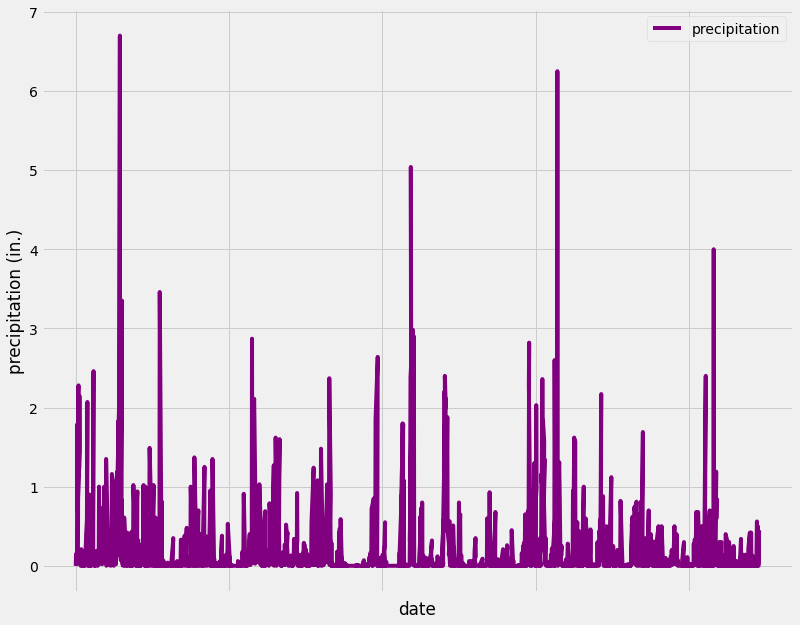

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=date_precip_df.plot(color='purple',figsize=(12,10),legend=True)
#hides our x ticks
ax.axes.xaxis.set_ticklabels([])
plt.xlabel("date")
plt.ylabel("precipitation (in.)")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
#checking column names and data types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.id)).all()

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity = session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).\
            order_by(func.count(measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = activity[0][0]
most_active_data = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == most_active).all()
most_active_data

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_year = session.query(measurement.tobs).\
                    filter(measurement.station == most_active).\
                    filter(measurement.date >= year_ago).all()
most_active_year_df = pd.DataFrame(most_active_year)
 
most_active_year_df = most_active_year_df.rename(columns = {"tobs":"temperature"})

most_active_year_df

,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


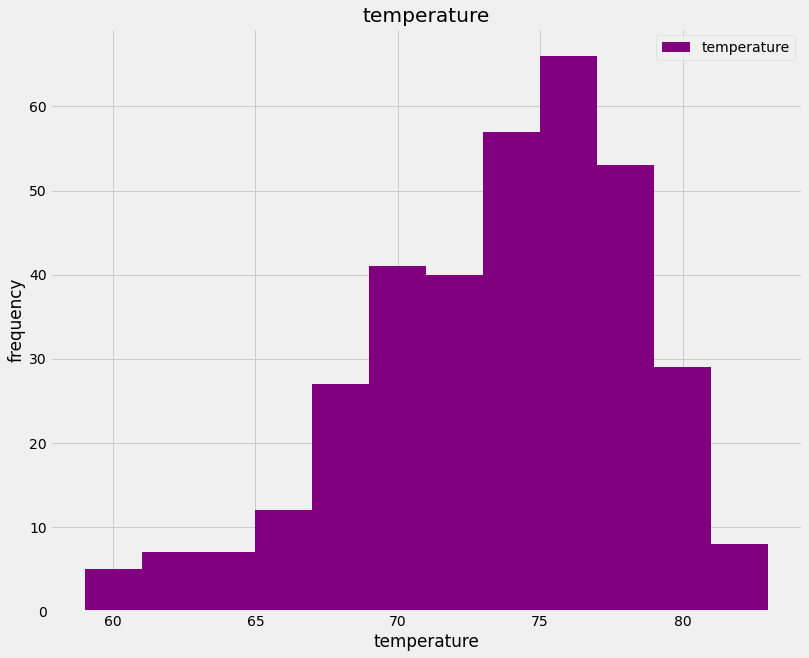

In [21]:
bx = most_active_year_df.hist(color='purple',bins = 12, figsize=(12,10),legend=True)
plt.xlabel("temperature")
plt.ylabel("frequency")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()